# K Nearest Neighbors

In this notebook we'll explore the K Nearest Neighbors algorithm.  As the name implies, the prediction for a new point is based on the closest $k$ points in the training set (where closest is usually defined in terms of Euclidiean distance on the $p$-dimensional feature space).  In math terms, we're taking the Euclidean distance between the $p$-vectors $X_{j\cdot}$ as our metric.  As a classificaiton algorithm, it takes a majority vote of the nearest $k$ neighbors.  As a regression algorithm, it takes the average label of the nearest $k$ neighbors.

## Some resources

1. [Wikipedia](http://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
1. The Scikit Learn package implements [K Nearest Neighbors](http://scikit-learn.org/stable/modules/neighbors.html).  It has both a [`KNeighborsClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) and [`KNeighborsRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html).

In [1]:
# Load and display a sample of the iris dataset

from sklearn import neighbors, datasets
import pandas as pd
import numpy as np

# load the data
# The iris data set labels 3 flower types (y) by 4 different attributes of the flower (X).
# For more about the attributes, see http://mldata.org/repository/data/viewslug/datasets-uci-iris/
data = datasets.load_iris()
X = pd.DataFrame(data.data, columns=["sepal_length", "sepal_width", "petal_legnth", "petal_width"])
y = pd.Series(data.target)
X.head()

,sepal_length,sepal_width,petal_legnth,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
# Process the nearest neighbors
nearest_neighbors = neighbors.NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nearest_neighbors.fit(X)
distances, indices = nearest_neighbors.kneighbors(X)

# Column $k$ gives the distances between each point and its $k$-th nearest neighbor from 0 to 4
# Column 0 is always itself.
# Each row is a separate point (note the first column)
print ("Distance")
print (pd.DataFrame(distances).head())
print ("Indices")
print (pd.DataFrame(indices).head())

Distance
     0         1         2         3         4
0  0.0  0.100000  0.141421  0.141421  0.141421
1  0.0  0.141421  0.141421  0.173205  0.173205
2  0.0  0.141421  0.244949  0.264575  0.264575
3  0.0  0.141421  0.173205  0.223607  0.244949
4  0.0  0.141421  0.173205  0.173205  0.223607
Indices
   0   1   2   3   4
0  0  17   4  39  27
1  1  45  12  34  37
2  2  47   3  12   6
3  3  47  29  30   2
4  4   0  17  40   7


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


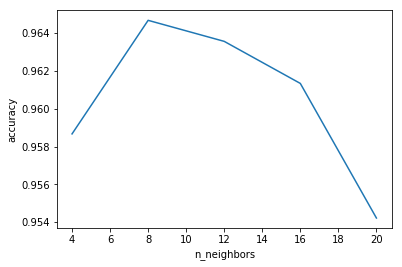

In [15]:
# We illustrate the effect of the number of neigbhors used on accruacy.

from sklearn import neighbors, model_selection
import matplotlib.pylab as plt

cv = model_selection.ShuffleSplit(len(y), test_size=0.2, random_state=42)
param_grid = { "n_neighbors": range(4, 24, 4) }
nearest_neighbors_cv = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), 
                                                param_grid=param_grid, cv=cv, 
                                                scoring='accuracy')

nearest_neighbors_cv.fit(X, y)
cv_accuracy = pd.DataFrame.from_records(
    [(score.parameters['n_neighbors'],
      score.mean_validation_score)
     for score in nearest_neighbors_cv.grid_scores_],
columns=['n_neighbors', 'accuracy'])

plt.plot(cv_accuracy.n_neighbors, cv_accuracy.accuracy)
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.show()

## Normalizing Data.

Based on your answer to the last question, we will want to scale the individual features so that they have similar variance.  For each feature, we are going to subtract the mean and divide by the standard deviation:

$$ X_{ji}' = \frac{X_{ji} - \mu_i}{\sigma_i} $$

where $\mu_i$ is the mean of the $i$-th column (or feature) and $\sigma_i$ is the standard deviation.

**Question**: For $k$-Nearest-Neighbors, was subtracting the mean necessary?  For what other algorithms might subtracting the mean help?

In [17]:
from sklearn import preprocessing

# first, let's see what the standard deviations are.
scaler = preprocessing.StandardScaler(copy=True).fit(X)
pd.DataFrame({
    "Mean": scaler.mean_,
    "Std": scaler.scale_
}, index=X.columns)

,Mean,Std
sepal_length,5.843333,0.825301
sepal_width,3.054000,0.432147
petal_legnth,3.758667,1.758529
petal_width,1.198667,0.760613


In [18]:
X_copy = X.copy()  # Feature (bug?): transform modifies the original 
X_scaled = scaler.transform(X_copy)
pd.DataFrame({
    "Mean": X_scaled.mean(axis=0), 
    "Std": X_scaled.std(axis=0)
})

,Mean,Std
0,-1.468455e-15,1.0
1,-1.657933e-15,1.0
2,-1.515825e-15,1.0
3,-8.052818e-16,1.0


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


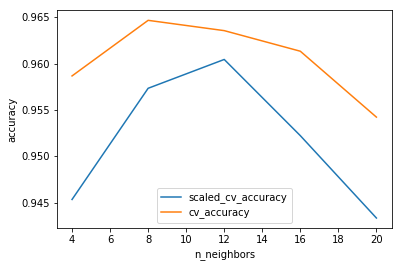

In [20]:
# We are going to first scale and then apply KNeighbors.
# Pipeline allows us to chain together multiple transformers and then a regressor or classifier

from sklearn.pipeline import Pipeline

scaled_nearest_neighbors = Pipeline([('scaling', preprocessing.StandardScaler(copy=True)), 
                                     ('neighbors', neighbors.KNeighborsClassifier())])

param_grid = { "neighbors__n_neighbors": range(4, 24, 4) }    # parameters to Pipeline take the form [label]__[estimator_param]
scaled_nearest_neighbors_cv = model_selection.GridSearchCV(scaled_nearest_neighbors, 
                                                       param_grid=param_grid, cv=cv, 
                                                       scoring='accuracy')

scaled_nearest_neighbors_cv.fit(X, y)
scaled_cv_accuracy = pd.DataFrame.from_records(
    [(score.parameters['neighbors__n_neighbors'],
      score.mean_validation_score)
     for score in scaled_nearest_neighbors_cv.grid_scores_],
columns=['n_neighbors', 'accuracy'])

plt.plot(scaled_cv_accuracy.n_neighbors, scaled_cv_accuracy.accuracy, label="scaled_cv_accuracy")
plt.plot(cv_accuracy.n_neighbors, cv_accuracy.accuracy, label="cv_accuracy")
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.legend(loc='lower center')
plt.show()